<a href="https://colab.research.google.com/github/mrigakshipandey/Personal/blob/master/Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long Short Term Memory
This is a special neuron for memorizing long-term dependencies. LSTM contains an internal state variable which is passed from one cell to the other and modified by Operation Gates (we’ll discuss this later in our example).

LSTM is smart enough to determine how long to hold onto old information, when to remember and forget, and how to make connections between old memory with the new input.

***Importing Libraries***

In [0]:
#Install dependency Libraries
!pip install tensorflow #LSTM implementation
!pip install numpy #matrix manipulation
!pip install pandas #data structure
!pip install matplotlib #visualiation
!pip install scikit-learn #Scaling

#import
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline

***Uploading Dataset***

In [0]:
#get the colab upload option
from google.colab import files
uploaded=files.upload()

Saving btc.csv to btc (1).csv


In [0]:
#reading the file
btc=pd.read_csv(io.StringIO(uploaded['btc.csv'].decode('utf-8')))
btc.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


***Target data***

In [0]:
#select target data
data_to_use=btc['Close'].values
data_to_use

array([7520.  , 7459.11, 7584.15, ...,  378.  ,  378.  ,  370.  ])

***Fit data into our model***

In [0]:
#data preprocessing
scaler=StandardScaler()
scaled_data=scaler.fit_transform(data_to_use.reshape(-1,1))

***Features and label***

This function is used to create the features and labels for our data set by windowing the data.

Input: data — this is the dataset we are using .

Window_size — how many data points we are going to use to predict the next datapoint in the sequence. (Example if window_size=7 we are going to use the previous 7 days to predict the bitcoin price for today).

Outputs: X — features split into windows of data points(if windows_size=1, X=[len(data)-1,1]).

y — labels — this is the next number in the sequence that we’re trying to predict.



In [0]:
def window_data(data, window_size):
  X=[]
  y=[]
  
  i=0
  while(i+window_size)<=len(data)-1:
    X.append(data[i:i+window_size])
    y.append(data[i+window_size])
    
    i+=1
  assert len(X)==len(y)
  return X,y
  
X,y=window_data(scaled_data,7)

***Testing and training datasets***

We have used 80% (1018) of the dataset as the training set and the remaining 20% (248) as the validation set.

In [0]:
X_train=np.array(X[:1018])
y_train=np.array(y[:1018])

X_test=np.array(X[1018:])
y_test=np.array(y[1018:])

print("X_train size : {}".format(X_train.shape))
print("y_train size : {}".format(y_train.shape))
print("X_test size : {}".format(X_test.shape))
print("y_test size : {}".format(y_test.shape))

X_train size : (1018, 7, 1)
y_train size : (1018, 1)
X_test size : (248, 7, 1)
y_test size : (248, 1)


***Hyperparameters***

Hyperparameters explain higher-level structural information about a model.

batch_size — This is the number of windows of data we are passing at once.

window_size — The number of days we consider to predict the bitcoin price for our case.

hidden_layers — This is the number of units we use in our LSTM cell.

clip_margin — This is to prevent exploding the gradient — we use clipper to clip gradients below above this margin.

learning_rate — This is a an optimization method that aims to reduce the loss function.

epochs — This is the number of iterations (forward and back propagation) our model needs to make.

***place holders***

***LSTM Weights***

LSTM weights are determined by Operation Gates which include: Forget, Input and Output gates.

*Forget Gate*

ft =σ(Wf[ht-1,Xt]+bf)

This is a sigmoid layer that takes the output at t-1 and the current input at time t and then combines them into a single tensor. It then applies linear transformation followed by a sigmoid.

The output of the gate is between 0 and 1 due to the sigmoid. This number is then multiplied with the internal state, and that is why the gate is called forget gate. If ft =0 ,then the previous internal state is completely forgotten, while if ft =1, it will be passed unaltered.

*Input Gate*

it=σ(Wi[ht-1,Xt]+bi)

This state takes the previous output together with the new input and passes them through another sigmoid layer. This gate returns a value between 0 and 1. The value of the input gate is then multiplied with the output of the candidate layer.

Ct=tanh(Wi[ht-1,Xt]+bi)

This layer applies hyperbolic tangent to the mix of the input and previous output, returning the candidate vector. The candidate vector is then added to the internal state, which is updated with this rule:

Ct=ft *Ct-1+it*Ct

The previous state is multiplied by the forget gate, and then added to the fraction of the new candidate allowed by the output gate.

*Output Gate*

Ot=σ(Wo[ht-1,Xt]+bo)

ht=Ot*tanh Ct

This gate controls how much of the internal state is passed to the output and works in a similar manner to the other gates.



***Network loop***

A loop for the network is created which iterates through every window in the batch

In [0]:
#we now define the network
#Hyperparameters used in the network
batch_size = 7 #how many windows of data we are passing at once
window_size = 7 #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 #How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001 
epochs = 200 

import tensorflow as tf
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])



#weights and implementation of LSTM cell
# LSTM weights

#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output
  
  
 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
  
    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
        
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs


[<tf.Tensor 'add_462:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_526:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_590:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_654:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_718:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_782:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_846:0' shape=(1, 1) dtype=float32>]

***Training the network***

We now train the network with the number of epochs (200), which we had initialized, and then observe the change in our loss through time. The current loss decreases with the increase in the epochs as observed, increasing our model accuracy in predicting the bitcoin prices.

In [0]:
#we define the loss
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))


Epoch 0/200  Current loss: 0.29258111119270325
Epoch 30/200  Current loss: 0.060699086636304855
Epoch 60/200  Current loss: 0.03094654716551304
Epoch 90/200  Current loss: 0.011491765268146992
Epoch 120/200  Current loss: 0.00939037837088108
Epoch 150/200  Current loss: 0.008093591779470444
Epoch 180/200  Current loss: 0.00837414525449276


In [0]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

In [0]:
tests = []
i = 0
while i+batch_size <= len(X_test): 
  
    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [0]:
tests_new = []
for i in range(len(tests)):
      for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

In [0]:
test_results = []
for i in range(1264):
      if i >= 1019:
        test_results.append(tests_new[i-1019])
      else:
        test_results.append(None)

***Predictions***

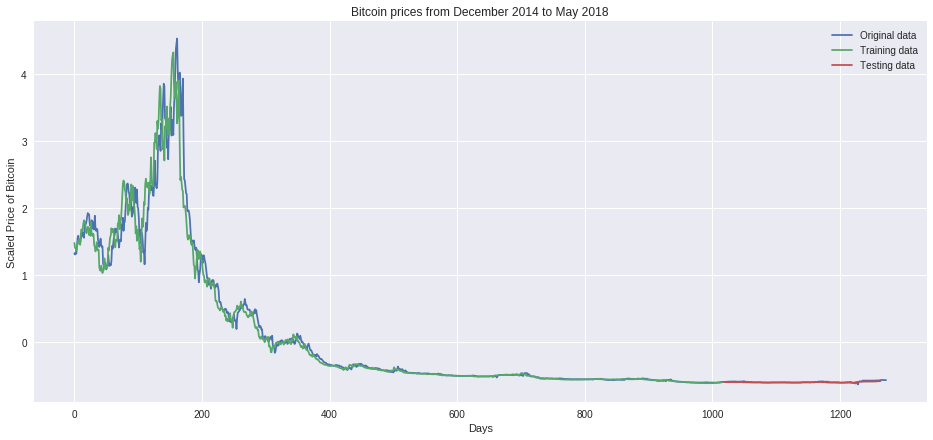

In [0]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()